In [267]:
"""
1. At the beginning of your code write a comment that states the topic of your research
project.

2. Some of you have outlined multiple questions to pursue. For this assignment pick ONE
of those questions and add it to the comments.
3. Many of you have outlined multiple ideas of plots to create or calculations to make.
For this assignment pick ONE of those ideas and add it to the comments.
4. The title of the code should be informative with regards to what the code does.
Queshtion
For my topic I will analysis now the inital galxies contribute to the final shape of the remant. 
I will do this by maping the density of MW,M31 and both combined as veiwed from the top down.
The queshtion I am trying to answer is: Once merged do M33/Mw stick to gether are create recognizable strucures in the remanant?

Step 1: combine M31 and MW halo particles inot one data, keeping track of which particles come from which system
    we want to use the previously made fucntions combine data, make new txt file with 8th columb with system
Step 2: find COM of combined data
    use center of mass function for this
Step 3: rotate system so we can view it face on
    Lab 7
Step 4: plot denisty of head on view
    step 4a: PLot just Mw particles
    step 4b: PLot just M31 particles
    step 4c: PLot both MW and M31 particles
step 5: extract x,y data points from density contor
steps 6: fit ellipse to x,y density contor

"""


'\n1. At the beginning of your code write a comment that states the topic of your research\nproject.\n\n2. Some of you have outlined multiple questions to pursue. For this assignment pick ONE\nof those questions and add it to the comments.\n3. Many of you have outlined multiple ideas of plots to create or calculations to make.\nFor this assignment pick ONE of those ideas and add it to the comments.\n4. The title of the code should be informative with regards to what the code does.\nQueshtion\nFor my topic I will analysis now the inital galxies contribute to the final shape of the remant. \nI will do this by maping the density of MW,M31 and both combined as veiwed from the top down.\nThe queshtion I am trying to answer is: Once merged do M33/Mw stick to gether are create recognizable strucures in the remanant?\n\nStep 1: combine M31 and MW halo particles inot one data, keeping track of which particles come from which system\n    we want to use the previously made fucntions combine data,

In [269]:



# import modules
import numpy as np
import astropy.units as u
from astropy.constants import G

# import plotting modules
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import colormaps

# my modules
from ReadFile import Read
from CenterOfMassCopy1 import CenterOfMass
from MassProfile import MassProfile

from Lab7_RotateFrame import RotateFrame as RF
from ConcatenateHalo import ConcatenateHalo
 
# for contours
import scipy.optimize as so
#import specific photutils moduesl needed to fit ellipse

from photutils.isophote import EllipseGeometry
from photutils.aperture import EllipticalAperture
from photutils.isophote import Ellipse

from ConvertData import ConvertData


In [ ]:
"""Before running code use ConcatenateHalo function to form 
txt file with combine M31 and MW file"""

In [ ]:
ConcatenateHalo('MW_630.txt', 'M31_630.txt', "HighResMWM31")

In [11]:
# Create a COM of object for for combined particles using center of mass object from HW 4
COMD = CenterOfMass("HighResMWM31.txt",1)

In [12]:
# Compute COM of all halo particles
COMP = COMD.COM_P(0.1)

COMV = COMD.COM_V(COMP[0],COMP[1],COMP[2])
# Determine positions of helo particles relative to COM 
xD = COMD.x - COMP[0].value 
yD = COMD.y - COMP[1].value 
zD = COMD.z - COMP[2].value 

# total magnitude
rtot = np.sqrt(xD**2 + yD**2 + zD**2)

# Determine velocities of particles relatiev to COM motion
vxD = COMD.vx - COMV[0].value 
vyD = COMD.vy - COMV[1].value 
vzD = COMD.vz - COMV[2].value 

# total velocity 
vtot = np.sqrt(vxD**2 + vyD**2 + vzD**2)

# Arrays for r and v 
r = np.array([xD,yD,zD]).T # transposed 
v = np.array([vxD,vyD,vzD]).T

In [233]:

def density_contour(xdata, ydata, nbins_x, nbins_y, ax=None, **contour_kwargs):
    """ Create a density contour plot.
    Parameters
    ----------
    xdata : numpy.ndarray
    ydata : numpy.ndarray
    nbins_x : int
        Number of bins along x dimension
    nbins_y : int
        Number of bins along y dimension
    ax : matplotlib.Axes (optional)
        If supplied, plot the contour to this axis. Otherwise, open a new figure
    contour_kwargs : dict
        kwargs to be passed to pyplot.contour()
        
    Example Usage
    -------------
     density_contour(x pos, y pos, contour res, contour res, axis, colors for contours)
     e.g.:
     density_contour(xD, yD, 80, 80, ax=ax, 
         colors=['red','orange', 'yellow', 'orange', 'yellow'])

    """

    H, xedges, yedges = np.histogram2d(xdata, ydata, bins=(nbins_x,nbins_y), density=True)
    # NOTE : if you are using the latest version of python, in the above: 
    # instead of normed=True, use density=True
    
    x_bin_sizes = (xedges[1:] - xedges[:-1]).reshape((1,nbins_x))
    y_bin_sizes = (yedges[1:] - yedges[:-1]).reshape((nbins_y,1))

    pdf = (H*(x_bin_sizes*y_bin_sizes))
    
    X, Y = 0.5*(xedges[1:]+xedges[:-1]), 0.5*(yedges[1:]+yedges[:-1])
    Z = pdf.T
    fmt = {}
    
    ### Adjust Here #### 
    
    # Contour Levels Definitions
    one_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.68))
    two_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.95))
    three_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.99))
    
    # You might need to add a few levels
    onetwo_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.75))


    # Array of Contour levels. Adjust according to the above
    levels = [one_sigma, onetwo_sigma, two_sigma, three_sigma][::-1]
    
    # contour level labels  Adjust accoding to the above.
    strs = ['0.75', '0.8', '0.95', '0.99'][::-1]

    
    ###### 
    
    if ax == None:
        contour = plt.contour(X, Y, Z, levels=levels, origin="lower", **contour_kwargs)
        for l, s in zip(contour.levels, strs):
            fmt[l] = s
        plt.clabel(contour, contour.levels, inline=True, fmt=fmt, fontsize=12)

    else:
        contour = ax.contour(X, Y, Z, levels=levels, origin="lower", **contour_kwargs)
        for l, s in zip(contour.levels, strs):
            fmt[l] = s
        ax.clabel(contour, contour.levels, inline=True, fmt=fmt, fontsize=12)
    
    return contour

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-10938.29  , -10916.3752, -10894.4604, ...,  10932.6804,
         10954.5952,  10976.51  ]),
 array([-10991.2   , -10969.6329, -10948.0658, ...,  10532.7658,
         10554.3329,  10575.9   ]),
 <matplotlib.collections.QuadMesh at 0x1521e0d9e10>)

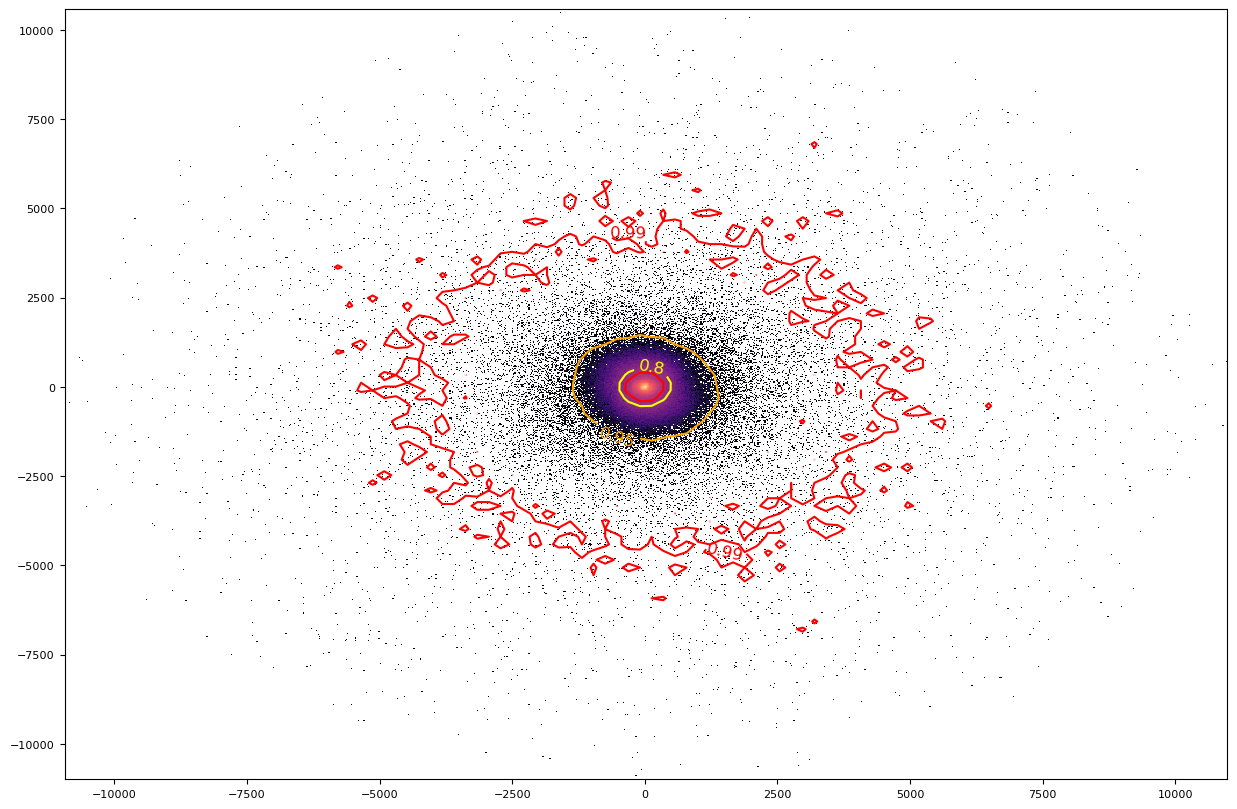

In [237]:
#plot density contor ar chosen precentage of mass and 
#estimate radius to use in filling ellipse latter on
fig, ax= plt.subplots(figsize=(15, 10))
density_contour(r[:,0],r[:,1], 100, 100, ax=ax,colors=['red','orange', 'yellow'])
ax.hist2d(r[:,0],r[:,1],bins=1000, norm=LogNorm(), cmap='magma')

In [226]:
#find new positaion and velocity vectors after frame is rotated
rn, vn = RF(r,v)

In [18]:
#create index to select paricles from spescific system 1=MW 2=M31
indexMW = np.where(halo[:,8] == 1)
indexM31 = np.where(halo[:,8] == 2)

In [19]:
#apply indexs to seperate MW and M31 particles
rMW=rn[indexMW]
rM31=rn[indexM31]

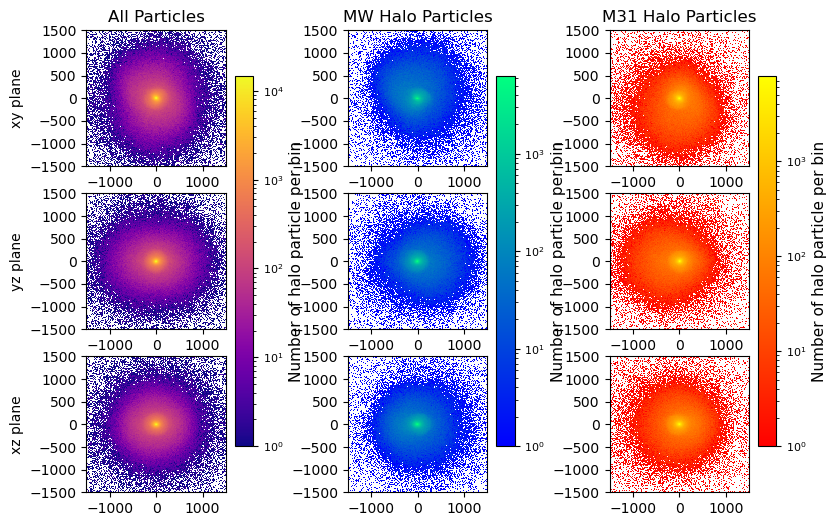

In [20]:
# Rotated MW-M31 halo

#Set up 3x3 plot
fig, ax = plt.subplots(3, 3,figsize=(9,6))

fig.subplots_adjust(wspace=0.5)

#plot all particles
#fig.tight_layout()

#plot all particles in xy plane
ax00=ax[0, 0].hist2d(rn[:,0],rn[:,1], bins=1000, norm=LogNorm(), cmap='plasma')
ax[0, 0].set_title('All Particles')
#plot just MW particles in xy
ax01=ax[0, 1].hist2d(rMW[:,0],rMW[:,1], bins=1000, norm=LogNorm(), cmap='winter')
ax[0, 1].set_title('MW Halo Particles')
#plot M31 in xy
ax02=ax[0, 2].hist2d(rM31[:,0],rM31[:,1], bins=1000, norm=LogNorm(), cmap='autumn')
ax[0, 2].set_title('M31 Halo Particles')
#plot all particles in yz plane
ax10=ax[1, 0].hist2d(rn[:,1],rn[:,2], bins=1000, norm=LogNorm(), cmap='plasma')

#plot just MW particles in yz
ax11=ax[1, 1].hist2d(rMW[:,1],rMW[:,2], bins=1000, norm=LogNorm(), cmap='winter')

#plot M31 in yz
ax12=ax[1, 2].hist2d(rM31[:,1],rM31[:,2], bins=1000, norm=LogNorm(), cmap='autumn')

#plot all particles in xz plane
ax20=ax[2, 0].hist2d(rn[:,0],rn[:,2], bins=1000, norm=LogNorm(), cmap='plasma')
#plot just MW particles in xz
ax21=ax[2, 1].hist2d(rMW[:,0],rMW[:,2], bins=1000, norm=LogNorm(), cmap='winter')

#plot M31 in xz
ax22=ax[2, 2].hist2d(rM31[:,0],rM31[:,2], bins=1000, norm=LogNorm(), cmap='autumn')

# label rows
ax[0, 0].set_ylabel('xy plane')
ax[1, 0].set_ylabel('yz plane')
ax[2, 0].set_ylabel('xz plane')

#limit veiw to -1500 kpc to 1500 kpc from center of galaxy for all perspectives
ax[0, 0].set_xlim(-1500,1500)
ax[0, 0].set_ylim(-1500,1500)

ax[0, 1].set_xlim(-1500,1500)
ax[0, 1].set_ylim(-1500,1500)

ax[0, 2].set_xlim(-1500,1500)
ax[0, 2].set_ylim(-1500,1500)

ax[1, 1].set_xlim(-1500,1500)
ax[1, 1].set_ylim(-1500,1500)

ax[1, 0].set_xlim(-1500,1500)
ax[1, 0].set_ylim(-1500,1500)

ax[1, 2].set_xlim(-1500,1500)
ax[1, 2].set_ylim(-1500,1500)

ax[2, 0].set_xlim(-1500,1500)
ax[2, 0].set_ylim(-1500,1500)

ax[2, 1].set_xlim(-1500,1500)
ax[2, 1].set_ylim(-1500,1500)

ax[2, 2].set_xlim(-1500,1500)
ax[2, 2].set_ylim(-1500,1500)


#adjust tick label font size
label_size = 8
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

#add color bar to all columbs
cAll=fig.colorbar(ax20[3], ax=ax[:, 0],shrink=0.8)
cMW=fig.colorbar(ax21[3], ax=ax[:, 1],shrink=0.8)
cM31=fig.colorbar(ax22[3], ax=ax[:, 2],shrink=0.8)

cAll.set_label("Number of halo particle per bin", fontsize=11)
cMW.set_label("Number of halo particle per bin", fontsize=11)
cM31.set_label("Number of halo particle per bin", fontsize=11)
# Save to a file 
plt.savefig('RemnantHaloDensity.png')


In [257]:
"convert xy data for there data sets in counts and the edges of data"

'convert xy data for there data sets in counts and the edges of data'

In [271]:
#all particles xy plane
countsxy, xedgesxy, yedgesxy, x_binsize, y_binsize= ConvertData(rn,0,1)

#M31 particles xy plane
counts31xy, xedges31, yedges31, x_binsize31, y_binsize31= ConvertData(rM31,0,1)

#M31 particles xy plane
countsWxy, xedgesW, yedgesW, x_binsizeW, y_binsizeW= ConvertData(rMW,0,1)


In [273]:
"convert yz data for there data sets in counts and the edges of data"

'convert yz data for there data sets in counts and the edges of data'

In [275]:

#all particles yz plane
countsyz, yedges, zedges , y_binsize, z_binsize= ConvertData(rn,1,2)
#M31 particles yz plane
counts31yz, yedges31, zedges31, y_binsize31, z_binsize31= ConvertData(rM31,1,2)
#MW particles yz plane
countsWyz, yedgesW, zedgesW, y_binsizeW, z_binsizeW= ConvertData(rMW,1,2)


In [276]:
"convert xz data for there data sets in counts and the edges of data"

'convert xz data for there data sets in counts and the edges of data'

In [279]:
#all particles yz plane
countsxz, xedges, zedges, x_binsize, z_binsize= ConvertData(rn,0,2) 
#M31 particles xz plane
counts31xz, xedges31, zedges31, x_binsize31, z_binsize31= ConvertData(rM31,0,2)
#MW particles xz plane
countsWxz, xedgesW, zedgesW, x_binsizeW, z_binsizeW= ConvertData(rMW,0,2)


In [281]:
"find center pixles for x,y,z"

'find center pixles for x,y,z'

In [283]:
#converting the center into pixel units for all paricles
#this location is close enough for both MW and M31 
#no other center is needed for calculations
x_cen_pixel = -xedges[0]/x_binsize
y_cen_pixel = -yedges[0]/y_binsize
z_cen_pixel = -zedges[0]/z_binsize


In [285]:
"""generate the gemoerty for each plane
ellipses are more or less centerd on the same spot
This means we can generate one geomerty for each 
plane instead of one for each plane and data set"""

'generate the gemoerty for each plane\nellipses are more or less centerd on the same spot\nThis means we can generate one geomerty for each \nplane instead of one for each plane and data set'

In [289]:
#defining the ellipse geometry 
geometry = EllipseGeometry(x0 = x_cen_pixel, y0 = y_cen_pixel, sma = 150/x_binsize, eps = 0, pa = 0)
#sma is the semi-major axis, eps is the ellipticity and pa is the position angle


In [291]:
"Fit elleipse using gemotry for xy"

'Fit elleipse using gemotry for xy'

In [293]:
ellipsexy = Ellipse(countsxy.T, geometry) #initializing the ellipse object all particles xy
#you need to transpose the counts matrix to reverse the effect of transposition that Ellipse does internally
isolistxy = ellipsexy.fit_image() 

ellipse31xy = Ellipse(counts31xy.T, geometry) #initializing the ellipse object M31 xy
#transpose
isolist31xy = ellipse31xy.fit_image() 

ellipseWxy = Ellipse(countsWxy.T, geometry) #initializing the ellipse object MW xy
#transpose
isolistWxy = ellipseWxy.fit_image() 

In [190]:
"Fit elleipse using gemotry for yz"

'Fit elleipse using gemotry for yz'

In [294]:
ellipseyz = Ellipse(countsyz.T, geometry) #initializing the ellipse object all paricles yz

isolistyz = ellipseyz.fit_image() 

ellipse31yz = Ellipse(counts31yz.T, geometry) #initializing the ellipse object M31 yz

isolist31yz = ellipse31yz.fit_image() 

ellipseWyz = Ellipse(countsWyz.T, geometry) #initializing the ellipse object MW yz
# transpose
isolistWyz= ellipseWyz.fit_image() 

In [295]:
"Fit elleipse using gemotry for xz"

'Fit elleipse using gemotry for xz'

In [296]:
ellipsexz = Ellipse(countsxz.T, geometry) #initializing the ellipse object all particles xz

isolistxz = ellipsexz.fit_image() 

ellipse31xz = Ellipse(counts31xz.T, geometry) #initializing the ellipse object M31 xz

isolist31xz = ellipse31xz.fit_image() 

ellipseWxz = Ellipse(countsWxz.T, geometry) #initializing the ellipse object MW xz
  
isolistWxz = ellipseWxz.fit_image() 

In [297]:
#plot fitted ellispes

In [298]:
# converst 500kpc to pixale size
sma = 500/x_binsize
#generate data for xy plane for ellipse with sma of 500 kpc

isoxy = isolistxy.get_closest(sma)#all
iso31xy = isolist31xy.get_closest(sma)#M31
isoWxy= isolistWxy.get_closest(sma)#MW

#generate data for yz plane for ellipse with sma of 500 kpc

isoyz = isolistyz.get_closest(sma)#all
iso31yz = isolist31yz.get_closest(sma)#M31
isoWyz = isolistWyz.get_closest(sma)#MW

#generate data for xz plane for ellipse with sma of 500 kpc

isoxz = isolistxz.get_closest(sma)#all
iso31xz = isolist31xz.get_closest(sma)#M31
isoWxz = isolistWxz.get_closest(sma)#Mw

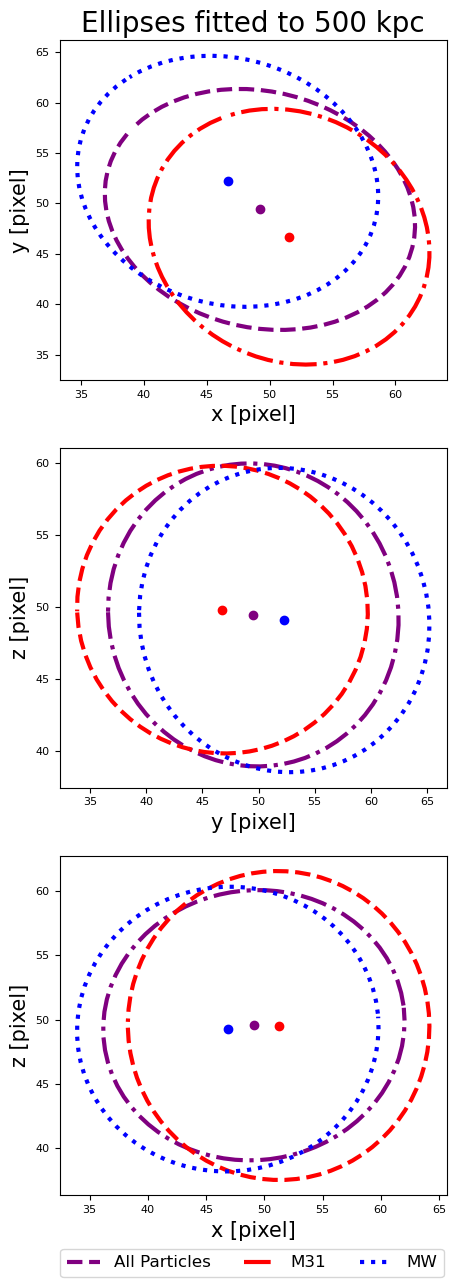

In [299]:
#generate figure
fig = plt.figure(figsize = (5, 15))
# add 3 plots
ax0 = fig.add_subplot(3, 1, 1)
ax1 = fig.add_subplot(3, 1, 2)
ax2 = fig.add_subplot(3, 1, 3)
#set title
ax0.set_title("Ellipses fitted to 500 kpc",fontsize=20)
#add labels to axis
ax0.set_xlabel('x [pixel]',fontsize=15)
ax0.set_ylabel('y [pixel]',fontsize=15)

ax1.set_xlabel('y [pixel]',fontsize=15)
ax1.set_ylabel('z [pixel]',fontsize=15)

ax2.set_xlabel('x [pixel]',fontsize=15)
ax2.set_ylabel('z [pixel]',fontsize=15)


#get and plot xy ellipses

#use sampled coordinates to find coordinates
x, y = isoxy.sampled_coordinates()
x31, y31 = iso31xy.sampled_coordinates()
xW, yW = isoWxy.sampled_coordinates()
#get center of each ellipse
cx,cy = isoxy.x0, isoxy.y0
cx31,cy31 = iso31xy.x0, iso31xy.y0
cxW,cyW = isoWxy.x0, isoWxy.y0
#plot ellipises
ax0.plot(x, y, color = 'purple', linewidth = 3, linestyle='--')
ax0.plot(x31, y31, color = 'red', linewidth = 3, linestyle='-.')
ax0.plot(xW, yW, color = 'blue', linewidth = 3, linestyle=':')
#add figure to the bottom of the graph
fig.legend(["All Particles", "M31","MW"],bbox_to_anchor=(0.51, 0.05), loc='outside lower center', ncols=3,fontsize=12)
#add center of each ellpise to the plot
ax0.plot(cx, cy, color = 'purple', marker='o')
ax0.plot(cx31, cy31, color = 'red', marker='o' )
ax0.plot(cxW, cyW, color = 'blue', marker='o')  

#get and plot yz ellipses

#use sampled coordinates to find coordinates
x, y = isoyz.sampled_coordinates()
x31, y31 = iso31yz.sampled_coordinates()
xW, yW = isoWyz.sampled_coordinates()
#plot ellipses
ax1.plot(x, y, color = 'purple', linewidth = 3, linestyle='-.')
ax1.plot(x31, y31, color = 'red', linewidth = 3, linestyle='--')
ax1.plot(xW, yW, color = 'blue', linewidth = 3, linestyle=':')
#get center of each ellipse
cx,cy = isoyz.x0, isoyz.y0
cx31,cy31 = iso31yz.x0, iso31yz.y0
cxW,cyW = isoWyz.x0, isoWyz.y0
#add center of each ellpise to the plot
ax1.plot(cx, cy, color = 'purple', marker='o')
ax1.plot(cx31, cy31, color = 'red', marker='o' )
ax1.plot(cxW, cyW, color = 'blue', marker='o')    

#get and plot xz ellipses

#use sampled coordinates to find coordinates
x, y = isoxz.sampled_coordinates()
x31, y31 = iso31xz.sampled_coordinates()
xW, yW = isoWxz.sampled_coordinates()
#plot ellipses
ax2.plot(x, y, color = 'purple', linewidth = 3, linestyle='-.')
ax2.plot(x31, y31, color = 'red', linewidth = 3, linestyle='--')
ax2.plot(xW, yW, color = 'blue', linewidth = 3, linestyle=':')
#get center of each ellipse
cx,cy = isoxz.x0, isoxz.y0
cx31,cy31 = iso31xz.x0, iso31xz.y0
cxW,cyW = isoWxz.x0, isoWxz.y0
#add center of each ellpise to the plot
ax2.plot(cx, cy, color = 'purple', marker='o')
ax2.plot(cx31, cy31, color = 'red', marker='o' )
ax2.plot(cxW, cyW, color = 'blue', marker='o')  
#save figure
plt.savefig('FittedEllipses.png')
plt.show()

In [155]:
#print ellpicitity of all ellipses
print("ellipticity all xy",isoxy.eps)
print("ellipticity MW xy",isoWxy.eps)
print("ellipticity M31 xy",iso31xy.eps)
print("ellipticity all yz",isoyz.eps)
print("ellipticity MW yz",isoWyz.eps)
print("ellipticity M31 yz",iso31yz.eps)
print("ellipticity all xz",isoxz.eps)
print("ellipticity MW xz",isoWxz.eps)
print("ellipticity M31 xz",iso31xz.eps)

ellipticity all xy 0.1279134261415709
ellipticity MW xy 0.11661029190892698
ellipticity M31 xy 0.16100535027329935
ellipticity all yz 0.1892494641963197
ellipticity MW yz 0.1862650416726096
ellipticity M31 yz 0.2296908935698696
ellipticity all xz 0.1863821792486872
ellipticity MW xz 0.14197977527886188
ellipticity M31 xz 0.06910605322559288


In [42]:
#print avredge ellipticies
ave=(isoxy.eps+isoWxy.eps+iso31xy.eps+isoyz.eps+isoWyz.eps+iso31yz.eps+isoxz.eps+isoWxz.eps+iso31xz.eps)/9
print("ave ellipticity",ave)

ave ellipticity 0.1564669417239709


In [43]:
#Find standard deivation of the elliptiicity sig=sum np.sqrt((xi-ave)^2/n)
sig=np.sqrt(((isoxy.eps-ave)**2+(isoWxy.eps-ave)**2+(iso31xy.eps-ave)**2
             +(isoyz.eps-ave)**2+(isoWyz.eps-ave)**2+(iso31yz.eps-ave)**2
             +(isoxz.eps-ave)**2+(isoWxz.eps-ave)**2+(iso31xz.eps-ave)**2)/9)
print("standard deivation",sig)

standard deivation 0.04532051886272333


In [44]:
#convert pixel scale of ellpises of kpc and find center

In [45]:
#get center condinates for ellpise in xy
cx,cy = isoxy.x0, isoxy.y0
cx31,cy31 = iso31xy.x0, iso31xy.y0
cxW,cyW = isoWxy.x0, isoWxy.y0

In [46]:
#convert for all ellpies in xy plane from pixle to kpc
cx=(cx*x_binsize)+xedges[0]
cy=(cy*y_binsize)+yedges[0]

cx31=(cx31*x_binsize)+xedges[0]
cy31=(cy31*y_binsize)+yedges[0]

cxW=(cxW*x_binsize)+xedges[0]
cyW=(cyW*y_binsize)+yedges[0]

In [47]:
#print new centers
print("center all particles xy",cx,cy)
print("center M31 xy",cx31,cy31)
print("center MW xy",cxW,cyW)

center all particles xy -31.049601741473225 -23.54918179968854
center M31 xy 61.67963226916709 -131.73352451744927
center MW xy -133.546157748194 88.03690444043059


In [48]:
#print diffrence between the center of MW and M31 in xy
print(np.sqrt((cx31-cxW)**2+(cy31-cyW)**2))

293.9594368824265


In [49]:
#get center condinates for ellpise in yz
cx,cy = isoyz.x0, isoyz.y0
cx31,cy31 = iso31yz.x0, iso31yz.y0
cxW,cyW = isoWyz.x0, isoWyz.y0

In [50]:
#convert for all ellpies in yz plane from pixle to kpc
cx=(cx*y_binsize)+yedges[0]
cy=(cy*z_binsize)+zedges[0]

cx31=(cx31*y_binsize)+yedges[0]
cy31=(cy31*z_binsize)+zedges[0]

cxW=(cxW*y_binsize)+yedges[0]
cyW=(cyW*z_binsize)+zedges[0]

In [51]:
#print new centers
print("center all particles yz",cx,cy)
print("center M31 yz",cx31,cy31)
print("center M3W yz",cxW,cyW)

center all particles yz -18.897035939384068 -22.346844599967426
center M31 yz -128.85761109498708 -7.61909683208296
center M3W yz 91.1902043104401 -36.53391308446362


In [52]:
#print diffrence between the center of MW and M31 in yz
print(np.sqrt((cx31-cxW)**2+(cy31-cyW)**2))

221.93942341010506


In [53]:
#get center condinates for ellpise in xz
cx,cz = isoxz.x0, isoxz.y0
cx31,cz31 = iso31xz.x0, iso31xz.y0
cxW,czW = isoWxz.x0, isoWxz.y0

In [54]:
#convert for all ellpies in xz plane from pixle to kpc
cx=(cx*x_binsize)+xedges[0]
cz=(cz*z_binsize)+zedges[0]

cx31=(cx31*x_binsize)+xedges[0]
cz31=(cz31*z_binsize)+zedges[0]

cxW=(cxW*x_binsize)+xedges[0]
czW=(czW*z_binsize)+zedges[0]

In [55]:
#print new centers
print("center all particles xz",cx,cz)
print("center M31 xz",cx31,cz31)
print("center MW xz",cxW,czW)

center all particles xz -36.05251658659631 -17.67473744130598
center M31 xz 48.92201697633436 -18.630539964172385
center MW xz -125.599095017541 -29.749398686605673


In [56]:
#print diffrence between the center of MW and M31 in xz
print(np.sqrt((cx31-cxW)**2+(cy31-cyW)**2))

176.90021235286216
